# Описание проекта. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

## Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [1]:
!pip install catboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.7 MB ? eta -:--:--
    --------------------------------------- 1.6/101.7 MB 5.2 MB/s eta 0:00:20
   - -------------------------------------- 2.6/101.7 MB 4.9 MB/s eta 0:00:21
   - -------------------------------------- 3.1/101.7 MB 4.5 MB/s eta 0:00:22
   - -------------------------------------- 3.7/101.7 MB 4.0 MB/s eta 0:00:25
   - -------------------------------------- 4.2/101.7 MB 3.8 MB/s eta 0:00:26
   - -------------------------------------- 4.7/101.7 MB 3.6 MB/s eta 0:00:28
   -- ------------------------------------- 5.2/101.7 MB 3.3 MB/s eta 0:00:30
   -- ------------------------------------- 5.5/101.7 MB 3.0 MB/s eta 0:00:32
   -- ------------------------------------- 5.5/101.7 MB 3.0 MB/s eta 0:00:32
   -- ------------------------------------- 5.8/101.7 MB 2.8 MB/s eta 0:00:35
   -- ------------------------------------- 6.0/101.7 MB 2.6 MB/s eta 0:00:37


In [18]:
# Подключения библиотек
import os
import random
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# импортируем библиотеки для работы с progress bar
from tqdm import *
from tqdm.notebook import tqdm
tqdm.pandas()

# Импортируем модели
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor

# Импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV

# Импортируем pytorch
import torch
import torch.nn as nn

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print('CPU')

NVIDIA GeForce GTX 1660 SUPER


Зафиксируем `RANDOM_STATE`

In [14]:
RANDOM_STATE = 170125
set_seed(RANDOM_STATE)

Random seed set as 170125


## Шаг 1. Загрузка данных

Данные хранятся в `Sqlite`  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk`_time — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

In [15]:
DB_FILENAME = 'ds-plus-final.db'

In [19]:
def download_file(url, filename):
  with requests.get(url, stream=True) as r:
      r.raise_for_status()
      with open(filename, 'wb') as f:
          pbar = tqdm(total=int(r.headers['Content-Length']))
          for chunk in r.iter_content(chunk_size=8192):
              if chunk:
                  f.write(chunk)
                  pbar.update(len(chunk))

In [21]:
if not os.path.isfile(DB_FILENAME):
    download_file('https://code.s3.yandex.net/data-scientist/ds-plus-final.db', DB_FILENAME)

Объявим учетные данные для подключения к базе данных

In [22]:
engine = create_engine(f'sqlite:///{DB_FILENAME}', echo=False) 

In [23]:
def primary_table_information(engine, table, limit):
    select_10_query = '''
    SELECT *
    FROM {}
    LIMIT {}
    '''
    count_all_query = '''
    SELECT COUNT(*)
    FROM {}
    '''
    printmd(f"Количество строк: {pd.read_sql_query(count_all_query.format(table), con = engine)['COUNT(*)'][0]}")
    df = pd.read_sql_query(select_10_query.format(table, limit), con = engine)
    display(df.head(limit))

### Таблица `steel.data_arc`
- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

In [24]:
primary_table_information(engine, 'data_arc', 10)

Количество строк: 14876

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


### Таблица `steel.data_bulk`
- `key` — номер партии;
- `Bulk1 … Bulk15` — объём подаваемого материала.

In [25]:
primary_table_information(engine, 'data_bulk', 10)

Количество строк: 3129

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,None,None,None,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,None,None,None,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,None,None,None,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,None,None,None,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0
5,6,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,201.0,154.0
6,7,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,152.0,154.0
7,8,None,None,None,99.0,None,None,None,None,None,None,None,410.0,None,252.0,153.0
8,9,None,None,None,117.0,None,None,None,None,None,None,None,107.0,None,99.0,203.0
9,10,None,None,None,NaN,None,None,None,None,None,None,None,203.0,None,102.0,204.0


### Таблица `steel.data_bulk_time`
- `key` — номер партии;
- `Bulk1 … Bulk15` — время подачи материала.

In [26]:
primary_table_information(engine, 'data_bulk_time', 10)

Количество строк: 3129

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,None,None,None,2019-05-03 13:57:27,None,None,None,None,None,None,None,2019-05-03 13:48:52,None,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,None,None,None,2019-05-03 14:18:58,None,None,None,None,None,None,None,2019-05-03 14:41:26,None,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,None,None,None,2019-05-03 15:17:58,None,None,None,None,None,None,None,2019-05-03 15:17:58,None,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,None,None,None,2019-05-03 16:03:08,None,None,None,None,None,None,None,2019-05-03 16:03:08,None,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,None,None,None,None,None,None,None,None,None,None,None,2019-05-03 16:38:11,None,2019-05-03 16:34:24,2019-05-03 16:29:56


### Таблица `steel.data_gas`
- `key` — номер партии;
- `gas` — объём подаваемого газа.

In [27]:
primary_table_information(engine, 'data_gas', 10)

Количество строк: 3239

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


### Таблица steel.data_temp
- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

In [28]:
primary_table_information(engine, 'data_temp', 10)

Количество строк: 18092

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


### Таблица `steel.data_wire`
- `key` — номер партии;
- `Wire1 … Wire9` — объём подаваемых проволочных материалов.

In [29]:
primary_table_information(engine, 'data_wire', 10)

Количество строк: 3081

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None
5,6,99.109917,9.11456,None,None,None,None,None,None,None
6,7,98.061600,None,None,None,None,None,None,None,None
7,8,155.282394,None,None,None,None,None,None,None,None
8,9,113.393279,9.143681,None,None,None,None,None,None,None
9,10,81.244796,12.376,None,None,None,None,None,None,None


### Таблица `steel.data_wire_time`
- `key` — номер партии;
- `Wire1 … Wire9` — время подачи проволочных материалов.

In [30]:
primary_table_information(engine, 'data_wire_time', 10)

Количество строк: 3081

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,None,None,None,None,None,None,None
6,7,2019-05-03 14:18:58,None,None,None,None,None,None,None,None
7,8,2019-05-03 15:01:30,None,None,None,None,None,None,None,None
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,None,None,None,None,None,None,None
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,None,None,None,None,None,None,None


Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Объем данных позволяет загрузить их в DataFrame

In [31]:
data_arc_df = pd.read_sql_query("SELECT * FROM data_arc", con = engine)
data_bulk_df = pd.read_sql_query("SELECT * FROM data_bulk", con = engine)
data_bulk_time_df = pd.read_sql_query("SELECT * FROM data_bulk_time", con = engine)
data_gas_df = pd.read_sql_query("SELECT * FROM data_gas", con = engine)
data_temp_df = pd.read_sql_query("SELECT * FROM data_temp", con = engine)
data_wire_df = pd.read_sql_query("SELECT * FROM data_wire", con = engine)
data_wire_time_df = pd.read_sql_query("SELECT * FROM data_wire_time", con = engine)

## Шаг 2. Исследовательский анализ и предобработка данных

In [32]:
def draw_boxplots(df, cols, labels, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("")
    fig.suptitle(title, fontsize=30);

In [33]:
def draw_hists(df, cols, labels, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        df[cols[i]].hist(ax=axs[i])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("")
    fig.suptitle(title, fontsize=30);
    return fig, axs

In [34]:
def primary_info(df):
    display(df.head())
    display(df.info())
    printmd("**Пропущенные значения**")
    display(df.isna().sum())
    printmd(f"**Количество дубликатов: {df.duplicated().sum()}**")

### Проанализируйте исходные данные. Проверьте:
- Все ли таблицы содержат данные.
- Соответствует ли количество таблиц условию задачи.

### Для таблицы steel.data_arc:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Вам нужно либо удалить всю партию с аномальным значением, либо заменить аномальное значение, основываясь на нормальных наблюдениях.
- Попробуйте сгенерировать новые признаки, которые могут пригодиться при обучении: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами и другие.
- При агрегировании наблюдений по ключу учитывайте порядок арифметических действий: сначала сгенерируйте новые признаки, затем уже агрегируйте наблюдения.

In [35]:
primary_info(data_arc_df)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

**Пропущенные значения**

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

**Количество дубликатов: 0**

Пропущенных значений и дубликатов нет. Сгенерируем дополнительные признаки

In [36]:
# Переименуем столбцы
data_arc_df.rename(inplace=True, columns={
    "Начало нагрева дугой": "start_heat_time", 
    "Конец нагрева дугой": "stop_heat_time", 
    "Активная мощность": "active_power", 
    "Реактивная мощность": "reactive_power"
})

# Приведем дату к типу datatime
data_arc_df['start_heat_time'] = pd.to_datetime(data_arc_df['start_heat_time'], format="%Y-%m-%d %H:%M:%S")
data_arc_df['stop_heat_time'] = pd.to_datetime(data_arc_df['stop_heat_time'], format="%Y-%m-%d %H:%M:%S")

Добавим новые признаки:
- Длительность нагрева
- Суммарная мощность
- Отношение мощностей `Реактивная мощность/Активная мощность`

In [37]:
data_arc_df['heat_delta_seconds'] = (data_arc_df['stop_heat_time']-data_arc_df['start_heat_time']).dt.seconds
data_arc_df['total_power'] = (data_arc_df['active_power']+data_arc_df['reactive_power'])
data_arc_df['power_ratio'] = (data_arc_df['reactive_power']/data_arc_df['active_power'])

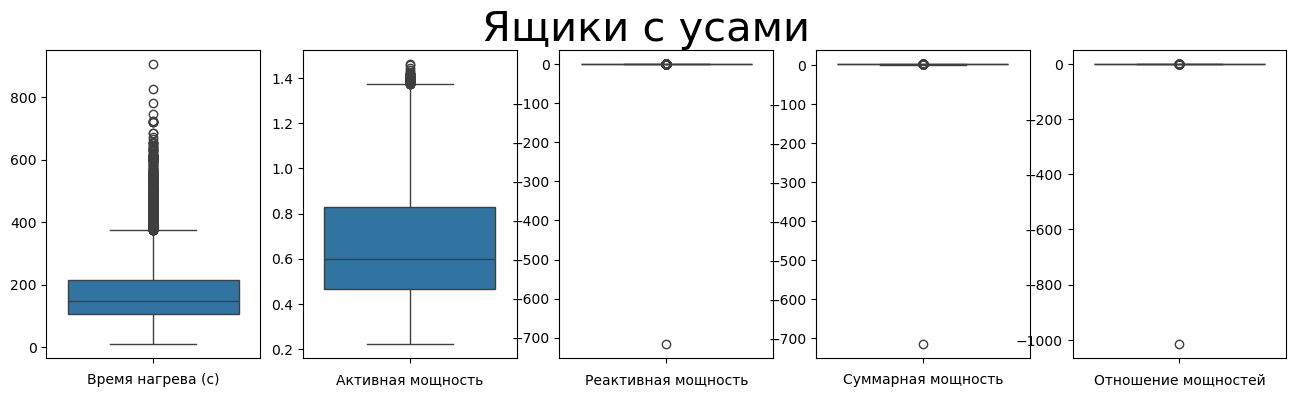

In [38]:
draw_boxplots(data_arc_df, 
              ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
              ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
               'Суммарная мощность', 'Отношение мощностей'],
              "Ящики с усами")

In [39]:
key = data_arc_df[data_arc_df['reactive_power'] < 0]['key']
data_arc_df = data_arc_df[~data_arc_df['key'].isin(key)]

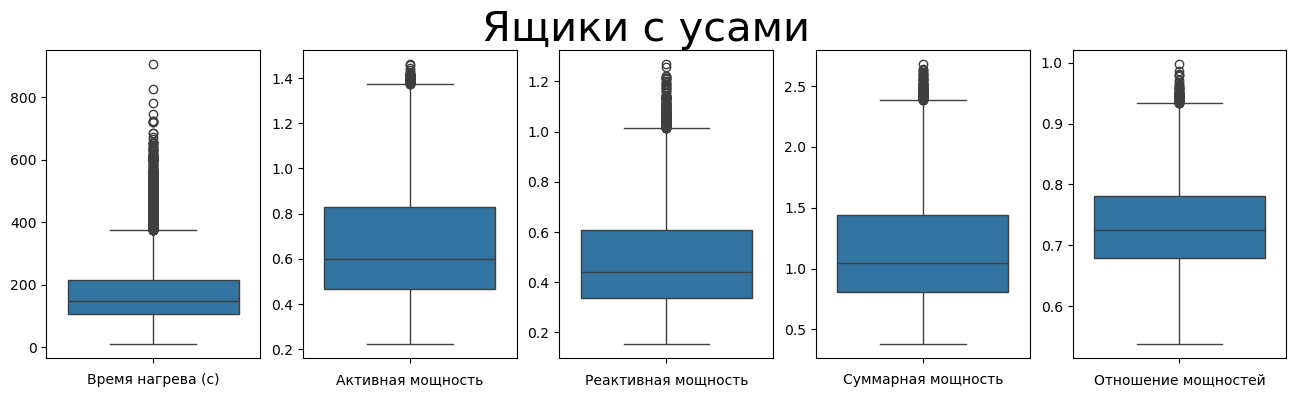

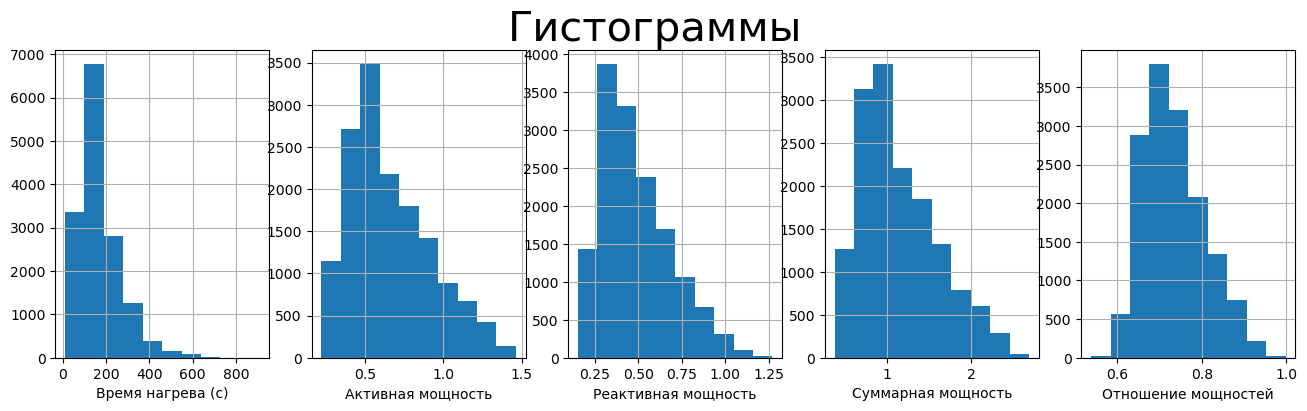

In [40]:
draw_boxplots(data_arc_df, 
              ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
              ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
               'Суммарная мощность', 'Отношение мощностей'],
              "Ящики с усами")
draw_hists(data_arc_df, 
           ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
           ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
            'Суммарная мощность', 'Отношение мощностей'],
           "Гистограммы");

In [41]:
data_arc_df.groupby('key').agg({
    'active_power': 'sum', 
    'reactive_power': 'sum',
    'total_power': 'mean', 
    'power_ratio': 'mean', 
    'key': 'count'
})

,active_power,reactive_power,total_power,power_ratio,key
key,,,,,
1,3.036730,2.142821,1.035910,0.706569,5
2,2.139408,1.453357,0.898191,0.684080,4
3,4.063641,2.937457,1.400220,0.725034,5
4,2.706489,2.056992,1.190870,0.765897,4
5,2.252950,1.687991,0.985235,0.758599,4
...,...,...,...,...,...
3237,2.541872,2.025417,0.913458,0.794276,5
3238,1.374821,1.038103,0.804308,0.757744,3
3239,4.848005,3.541541,1.048693,0.746212,8


### Для таблицы steel.data_bulk:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Обработайте пропуски. Пропуск означает, что материал не добавляли в партию.

In [42]:
primary_info(data_bulk_df)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.3+ KB


None

**Пропущенные значения**

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Количество дубликатов: 0**

In [43]:
bulk_idx = list([f"bulk_{x}" for x in range(1, 16)])

# Переименуем столбцы
data_bulk_df.rename(inplace=True, columns=dict(zip(
    list([f"Bulk {x}" for x in range(1, 16)]),
    bulk_idx
)))

# Приведем к типу float64
data_bulk_df[bulk_idx] = data_bulk_df[bulk_idx].astype('float64')

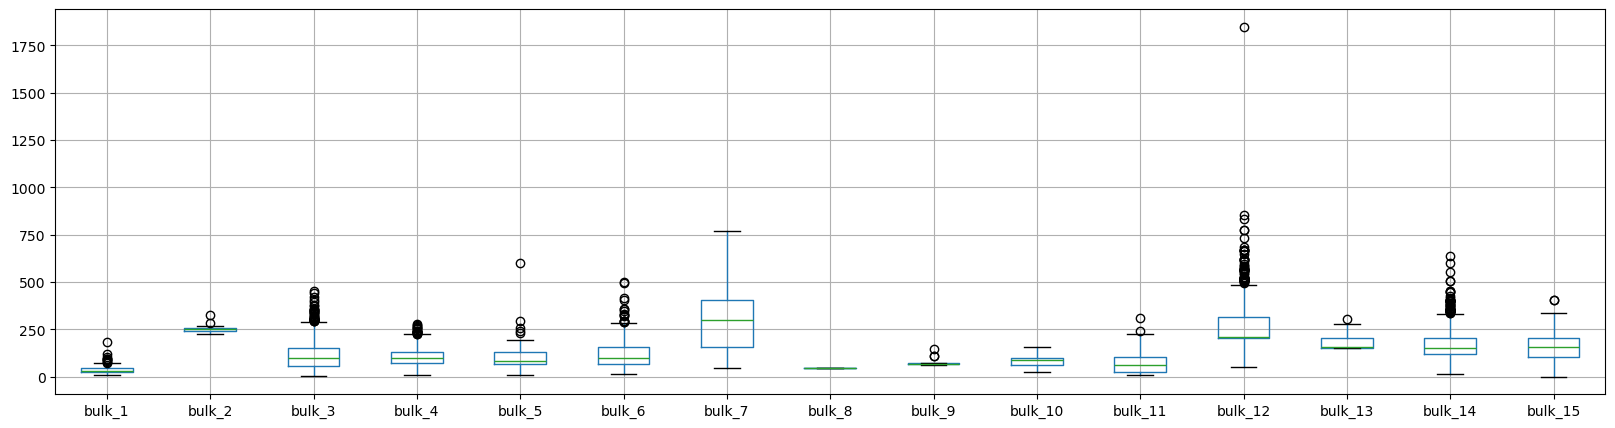

In [44]:
data_bulk_df.boxplot(column=bulk_idx, figsize=(20, 5));

Удалим аномальные значения в `bulk_12 > 1000` и `bulk_5 > 500`

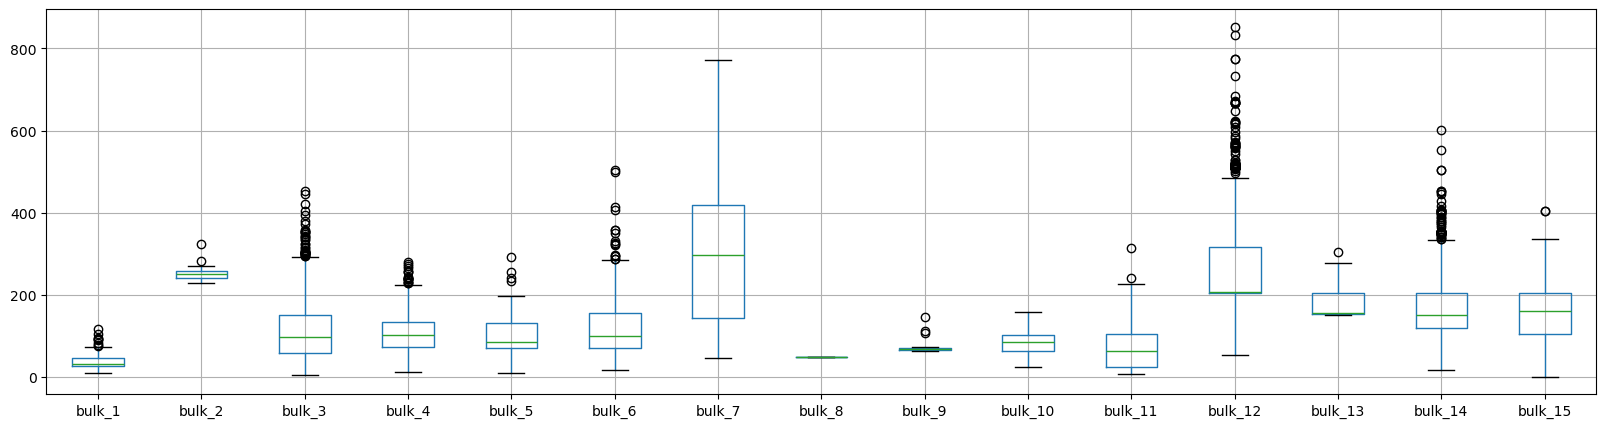

In [45]:
key = data_bulk_df[(data_bulk_df['bulk_5'] > 500) | (data_bulk_df['bulk_12'] > 1000)]['key']
data_bulk_df = data_bulk_df[~data_bulk_df['key'].isin(key)]
data_bulk_df.boxplot(column=bulk_idx, figsize=(20, 5));

In [46]:
data_bulk_df = data_bulk_df.fillna(0)

### Для таблицы steel.data_bulk_time:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.

In [47]:
primary_info(data_bulk_time_df)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

**Пропущенные значения**

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Количество дубликатов: 0**

In [48]:
# Переименуем столбцы
data_bulk_time_df.rename(inplace=True, columns=dict(zip(
    list([f"Bulk {x}" for x in range(1, 16)]),
    bulk_idx
)))

# Приведем к типу datetime
data_bulk_time_df[bulk_idx] = data_bulk_time_df[bulk_idx].apply(
    (lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S"))
)

In [126]:
def calc_delta(x):
    tt = [value for value in x[bulk_idx] if not pd.isnull(value)]
    return (max(tt)-min(tt)).seconds

  0%|          | 0/3129 [00:00<?, ?it/s]

<Axes: >

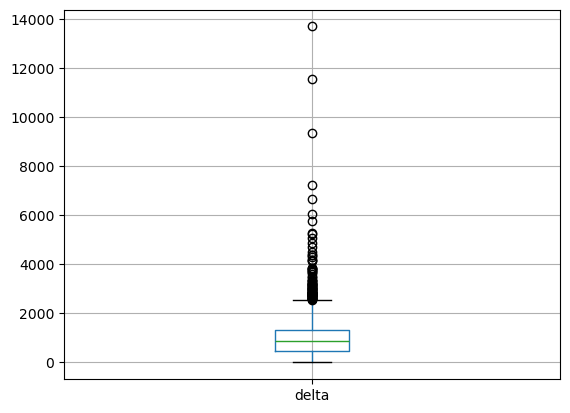

In [129]:
data_bulk_time_df['delta'] = data_bulk_time_df.progress_apply(calc_delta, axis=1)
data_bulk_time_df[['delta']].boxplot()

### Для таблицы steel.data_gas:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.

In [41]:
primary_info(data_gas_df)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

**Пропущенные значения**

key      0
Газ 1    0
dtype: int64

**Количество дубликатов: 0**

In [65]:
# Переименуем столбцы
data_gas_df.rename(inplace=True, columns={'Газ 1': 'gas'})

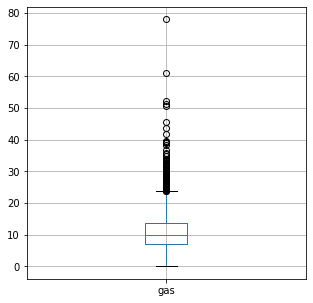

In [47]:
data_gas_df.boxplot(column='gas', figsize=(5, 5));

### Для таблицы steel.data_temp:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределения признаков.
- Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.
- При агрегировании наблюдений используйте только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.
- Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные.

In [51]:
primary_info(data_temp_df)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


None

**Пропущенные значения**

key                0
Время замера       0
Температура     3427
dtype: int64

**Количество дубликатов: 0**

In [55]:
data_temp_df.rename(inplace=True, columns={
    "Время замера": "measure_time", 
    "Температура": "temperature"
})

In [56]:
# Приведем дату к типу datatime
data_temp_df['measure_time'] = pd.to_datetime(
    data_temp_df['measure_time'], format="%Y-%m-%d %H:%M:%S"
)
# Приведем температуру к типу float64
data_temp_df['temperature'] = data_temp_df['temperature'].astype('float64')

### Для таблицы steel.data_wire:
- Обработайте пропуски. Пропуск означает, что материал не добавляли в эту партию.

In [52]:
primary_info(data_wire_df)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


None

**Пропущенные значения**

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

**Количество дубликатов: 0**

In [61]:
wire_idx = list([f"wire_{x}" for x in range(1, 10)])

# Переименуем столбцы
data_wire_df.rename(inplace=True, columns=dict(zip(
    list([f"Wire {x}" for x in range(1, 10)]),
    wire_idx
)))

# Преобразуем к типу float64
data_wire_df[wire_idx] = data_wire_df[wire_idx].astype('float64')

### Для таблицы steel.data_wire_time:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.

In [64]:
primary_info(data_wire_time_df)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

**Пропущенные значения**

key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

**Количество дубликатов: 0**

In [63]:
# Переименуем столбцы
data_wire_time_df.rename(inplace=True, columns=dict(zip(
    list([f"Wire {x}" for x in range(1, 10)]),
    wire_idx
)))

# Приведем к типу datetime
data_wire_time_df[wire_idx] = data_wire_time_df[wire_idx].apply(
    (lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S"))
)

### Объедините таблицы по ключу:
- Каждой партии должно соответствовать одно наблюдение.
- Учтите: во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался.
- Заказчик предупредил, что иногда наблюдается асинхронность в заданном времени разных датчиков. Если вы будете выстраивать хронологию процессов для разных партий, то можете столкнуться с тем, что полученная хронология не соответствует хронологии в описании. Не стоит воспринимать это как ошибку.
- Проведите исследовательский анализ данных объединённой таблицы и визуализируйте распределение каждого признака, напишите выводы.
- Проведите корреляционный анализ.

### Подготовьте данные для обучения:
- Выберите признаки, которые будете использовать для обучения, учитывайте особенности данных и выбранных моделей.
- Разделите данные на тренировочную и тестовую выборки (test_size = 0.25).
- Подготовьте выборки для обучения, учитывайте особенности выбранных моделей.

## Шаг 3. Обучение модели

### Решающее дерево или случайный лес

### Бустинги

### Нейронные сети

## Шаг 4. Тестирование модели и демонстрация её работы

## Шаг 5. Общий вывод по работе